# Etapa 1

## 1.1 Entendimiento del negocio y enfoque analítico

### 1.1.1 Oportunidad/Problema negocio

Categorizar los comentarios de las peliculas en positivos o negativos


### 1.1.2 Enfoque analítico

(Descripción del
requerimiento desde el
punto de vista de
aprendizaje automático)

Uso de tecnicas de aprendizaje automatico(machine learning) y procesamiento de lenguaje natural que tienen como objetivo principal procesar de manera automatica grandes cantidades de texto de los comentarios de las peliculas para poder clasificarlos en positivos o negativos


### 1.1.3 Organización y rol dentro de ella que se beneficia con la oportunidad definida

### 1.1.4 Técnicas y algoritmos a utilizar

a.) Tipo de aprendizaje : supervisado

b.) Tarea de aprendizaje : Clasificación 

c.) Tecnicas de aprendizaje : 

        1. SVM(Máquinas de vectores de soporte)
        2. Regresión logística
        3. Arboles de decisión


## 1.2 Entendimiento y preparación de los datos

### 1.2.1 Carga de los datos

In [64]:
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import contractions
import inflect
import pandas_profiling
import re

import warnings
warnings.filterwarnings('ignore')




nltk.data.path.append(os.path.abspath('./nltk_data'))
nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('stopwords', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('wordnet', quiet=True, raise_on_error=True, download_dir='./nltk_data')
ROOT_DIR = os.path.abspath(os.curdir)
NLTK_DATA_DIR = os.path.join(ROOT_DIR, 'nltk_data')
nltk.data.path.append(NLTK_DATA_DIR)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stopwords_spanish = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

df_movies = pd.read_csv('./data/MovieReviews.csv',
                        sep=',',
                        encoding='utf-8',
                        index_col=0)

# random_df = df_movies.sample(n=len(df_movies), replace=True)
# random_df.to_csv("./data/randomMovieReviews.csv", index=False)

# df_movies = pd.read_csv('./data/randomMovieReviews.csv',
#                         sep=',',
#                         encoding='utf-8',
#                         index_col=None)

### 1.2.2 Entendimiento de los datos

In [32]:
df_movies.shape

(5000, 2)

In [33]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,positivo
1,Supongo que algunos directores de películas de...,positivo
2,Es difícil contarle más sobre esta película si...,positivo
3,"La película comienza muy lentamente, con el es...",positivo
4,Esta película es verdadera acción en su máxima...,positivo


In [34]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    5000 non-null   object
 1   sentimiento  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [35]:
# Se calcula el porcentaje de los valores nulos por columna
print((df_movies.isnull().sum()*100 / df_movies.shape[0]).sort_values(ascending=False))

review_es      0.0
sentimiento    0.0
dtype: float64


In [36]:
# Analizar la duplicidad de los datos
df_movies.duplicated().sum()

2

<AxesSubplot:>

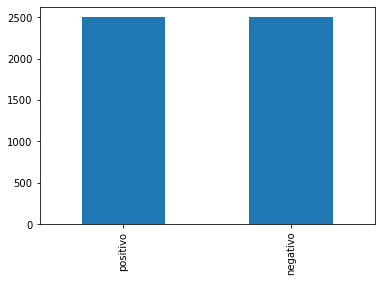

In [37]:
# Analizar distribución de la variable categórica
df_movies['sentimiento'].value_counts().plot(kind='bar')

In [38]:
# Para analizar la columna de review_es vamos a ver los reviews con menos de 30 caracteres
short_reviews = df_movies[df_movies['review_es'].str.len() < 50]
print(short_reviews)

Empty DataFrame
Columns: [review_es, sentimiento]
Index: []


Como puede evidenciarse, no hay filas con reviews cortos o vacíos que se podrían considerar como atípicos.

In [39]:
short_reviews = df_movies[df_movies['review_es'].str.len() < 61]
print(short_reviews)

# El review más corto tiene 61 caracteres, lo cual es un número apropiado.
print(short_reviews['review_es'])

                                              review_es sentimiento
4421  Esta película es terrible pero tiene algunos b...    negativo
4421    Esta película es terrible pero tiene algunos b...
Name: review_es, dtype: object


### 1.2.3 Preparación de los datos

In [40]:
# Se cambian los valores a numéricos
df_movies['sentimiento'] = df_movies['sentimiento'].replace({'positivo': 1, 'negativo': 0})

In [41]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1


In [42]:
df_movies.dtypes

review_es      object
sentimiento     int64
dtype: object

1    2500
0    2500
Name: sentimiento, dtype: int64


<AxesSubplot:>

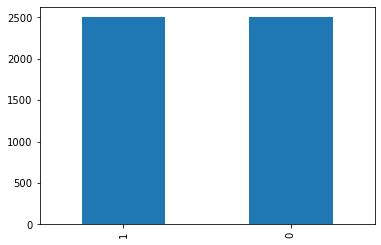

In [43]:
# Analizar distribución de la variable categórica
print(df_movies['sentimiento'].value_counts())
df_movies['sentimiento'].value_counts().plot(kind='bar',)

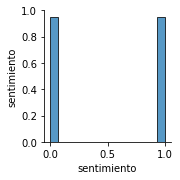

In [44]:
sns.pairplot(df_movies)

Finalmente, se eliminan los valores duplicados, los cuales solo eran 2.

In [45]:
print("Cantidad de datos duplicados: ",df_movies.duplicated().sum())
df_movies.drop_duplicates(inplace=True)
print("Cantidad de datos duplicados después: ",df_movies.duplicated().sum())

df_movies.shape

Cantidad de datos duplicados:  2
Cantidad de datos duplicados después:  0


(4998, 2)

En conclusión, se tienen 4998 filas para crear el modelo.

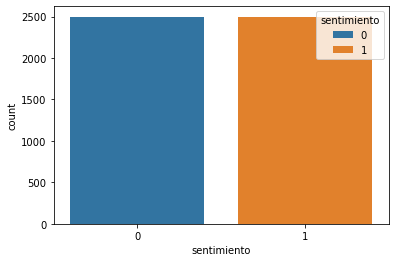

In [46]:
ax = sns.countplot(x="sentimiento", hue="sentimiento", data=df_movies, dodge=False)

In [47]:
df_movies.head(20)

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1
5,Así como un fanático de la vida de las películ...,1
6,"El polvo rojo está bien actuado y bien hecho, ...",1
7,Los talentos de Abbott y Costello brillan en l...,1
8,Asesina sexy Tiffany (Jennifer Tilly) todavía ...,1
9,"Si mis expectativas no se superaron, ciertamen...",1


### 1.2.4 Procesamiento de lenguaje natural

In [62]:

def preprocessor(text):
     text = re.sub('<[^>]*>', '', text)
     emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                            text)
     text = (re.sub('[\W]+', ' ', text.lower()) +
             ' '.join(emoticons).replace('-', ''))
     return text

In [65]:
df_movies['review_es'] = df_movies['review_es'].apply(preprocessor)

In [66]:
df_movies.head(20)

,review_es,sentimiento
0,si está buscando una película de guerra típica...,positivo
1,supongo que algunos directores de películas de...,positivo
2,es difícil contarle más sobre esta película si...,positivo
3,la película comienza muy lentamente con el est...,positivo
4,esta película es verdadera acción en su máxima...,positivo
5,así como un fanático de la vida de las películ...,positivo
6,el polvo rojo está bien actuado y bien hecho p...,positivo
7,los talentos de abbott y costello brillan en l...,positivo
8,asesina sexy tiffany jennifer tilly todavía an...,positivo
9,si mis expectativas no se superaron ciertament...,positivo


In [48]:

nltk.download('stopwords')
stop_words= set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# Función para tokenizar los tweets
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

In [50]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, y_train, y_test = train_test_split(df_movies['review_es'], df_movies['sentimiento'], test_size = 0.2, stratify = df_movies['sentimiento'], random_state = 1)

In [51]:
X_train.shape

(3998,)

In [52]:
pd.Series(y_train).value_counts(normalize = True)

1    0.5
0    0.5
Name: sentimiento, dtype: float64

In [53]:
X_test.shape

(1000,)

In [54]:
pd.Series(y_test).value_counts(normalize = True)

0    0.5
1    0.5
Name: sentimiento, dtype: float64

## Vectorización

In [55]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)


In [56]:
X_bow = bow.fit_transform(X_train)

In [57]:
len(bow.vocabulary_)

58806

In [59]:
tfidf=TfidfVectorizer(tokenizer=tokenizer, stop_words=stop_words, lowercase=True)

In [60]:
X_tfidf = tfidf.fit_transform(X_train)

In [61]:
len(tfidf.vocabulary_)

58806

## 1.3 Modelo y evaluación
Se requiere que llas variables de entrada estén separadas de la variable objetivo.

In [44]:
# TODO: Preguntar esto
# # Se selecciona la variable objetivo, en este caso "sentimiento".
# Y = df_movies['sentimiento']

# # Todos los datos sin la variable objetiv
# X = df_movies.drop(['sentimiento'], axis=1)
Y = df_movies['review_es']
X = df_movies.drop(['review_es'], axis=1)

# El 30% de los datos están para el testing y el 70% para el entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state=0)

### 1.3.1 Modelo con Support Vector Machines (SVMs)

#### 1.3.1.1 Construcción del modelo

In [45]:
# Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

# Entrenar el modelo utilizando los training sets
clf.fit(X_train, Y_train)

# Predecir la respuesta para el test dataset
Y_pred = clf.predict(X_test)

#### 1.3.1.2 Interpretación del modelo.

In [ ]:
# print("Precisión:", metrics.precision_score(Y_test, Y_pred))
# print("Recall:", metrics.recall_score(Y_test, Y_pred))
# print("Puntuación F1: ", metrics.f1_score(Y_test, Y_pred))
# print("Exactitud:", metrics.accuracy_score(Y_test, Y_pred))

#### 1.3.1.3 Construcción del modelo con búsqueda de hiperparámetros.

## 1.4 Resultados


## 1.5 Trabajo en equipo